#### Import libraries

In [45]:
import numpy as np
import pandas as pd 
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib


#### Load Dataset

In [13]:
airbnb_ds = pd.read_csv("./Dataset/Sprint2-Airbnb_dataset/AB_NYC_2019.csv")
print(f"Dataset loaded successfully : {airbnb_ds.shape[0]} records")

Dataset loaded successfully : 48895 records


##### Review Data

In [14]:
airbnb_ds.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365


##### Null check

In [12]:
airbnb_ds.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

##### Generate clean dataset

- Remove rows where **name** and **Host name** is null
- set 0 for **reviews_per_month** where data is null
- Remove rows with **price > 8000**

In [31]:
cleaned_airbnb_ds = airbnb_ds.dropna(subset=['name','host_name'])
cleaned_airbnb_ds['reviews_per_month'] = cleaned_airbnb_ds['reviews_per_month'].fillna(0)
cleaned_airbnb_ds = cleaned_airbnb_ds[cleaned_airbnb_ds['price'] <= 8000]

C:\Users\Khushbu.Lad\AppData\Local\Temp\ipykernel_12188\2459400135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_airbnb_ds['reviews_per_month'] = cleaned_airbnb_ds['reviews_per_month'].fillna(0)


#### Review clean dataset

In [32]:
cleaned_airbnb_ds.isnull().sum()

id                                    0
name                                  0
host_id                               0
host_name                             0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10035
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

### Exploratory Data Analysis (EDA)

##### Price distribution

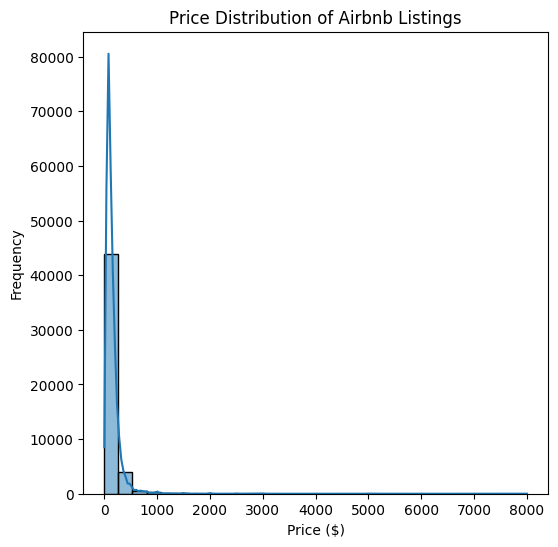

In [33]:
plt.figure(figsize=(6, 6))
sns.histplot(cleaned_airbnb_ds['price'], bins=30, kde=True)
plt.title('Price Distribution of Airbnb Listings')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()

- The histogram shows a right-skewed distribution, with most listings priced under $500. This insight is crucial for hosts to understand market pricing behavior. 
- Most Airbnb listings fall in the lower price range while a few exclusive listings drive the price distribution to the right. Dynamic pricing methods need to adjust accordingly because market changes remain evident.

##### Correlation heatmap

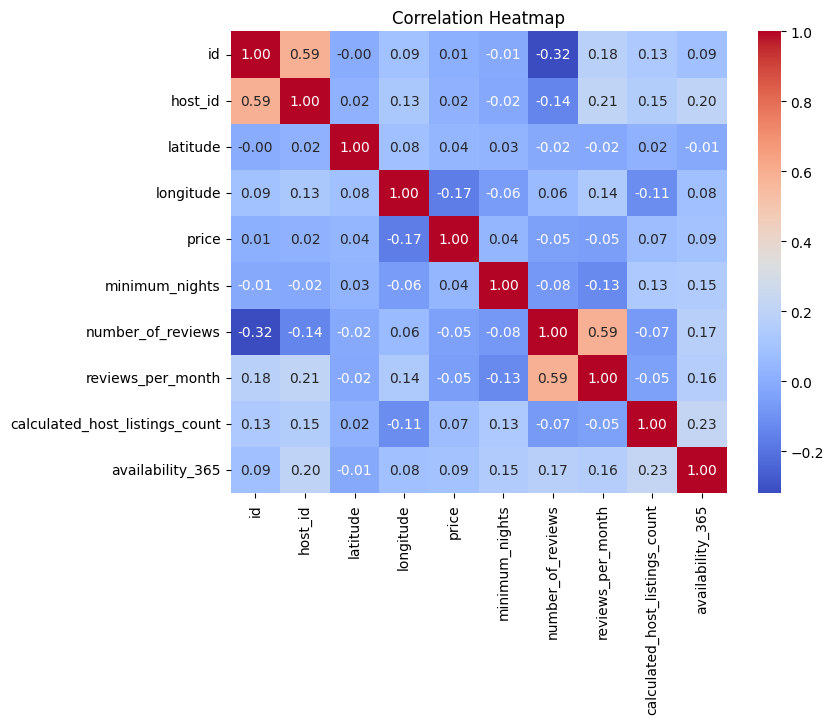

In [34]:
numeric_cols = cleaned_airbnb_ds.select_dtypes(include=[np.number])
plt.figure(figsize=(8, 6))
corr = numeric_cols.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

##### Analyze room type vs price

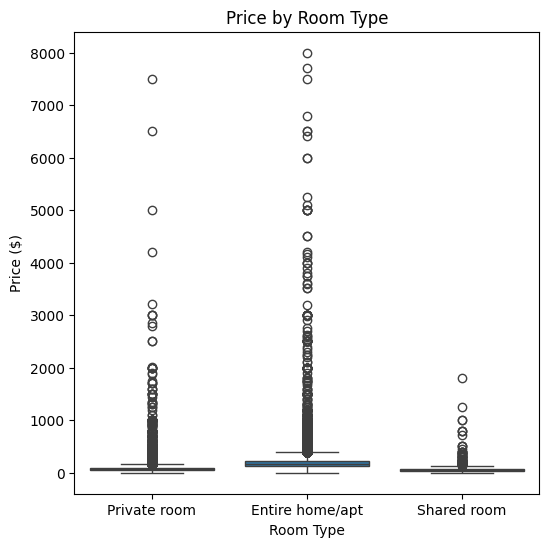

In [36]:
plt.figure(figsize=(6, 6))
sns.boxplot(x='room_type', y='price', data=cleaned_airbnb_ds)
plt.title('Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price ($)')
plt.show()


- The analysis through boxplots demonstrates "Entire home/apt" listings obtain notably increased prices compared to both "Private room" and "Shared room" options. The discovery informs hosts how to determine their service strategies by following possible profitability rates.

## Average Price by Neighbourhood Group
- Average house prices in each neighbourhood cluster show valuable information about market movements:
- The prices between different neighborhoods show substantial differences, and Manhattan remains at the peak of pricing.
- Insights:
    - Price knowledge assists hosts to establish market-appropriate rates depending on their geographical region.
    - The DSS employs this information to build pricing recommendations for particular neighborhoods.

## Average Price by Neighbourhood Group
- Average house prices in each neighbourhood cluster show valuable information about market movements:
- The prices between different neighborhoods show substantial differences, and Manhattan remains at the peak of pricing.
- Insights:
    - Price knowledge assists hosts to establish market-appropriate rates depending on their geographical region.
    - The DSS employs this information to build pricing recommendations for particular neighborhoods.

## Availability vs. Number of Reviews
- The data visualization using the scatter plot reveals new information through its examination of availability in relation to the quantity of reviews.
- The distribution of reviews shows marked diversity in relation to availability which implies that greater housing availability does not generate additional reviews.
- Insights:
    - Guests who manage their properties effectively or deliver perfect customer experiences can generate numerous reviews even if they maintain limited availability dates.
    - High availability in hosting does not consistently lead to more positive reviews as quality seems to matter more than the actual quantity of available days.

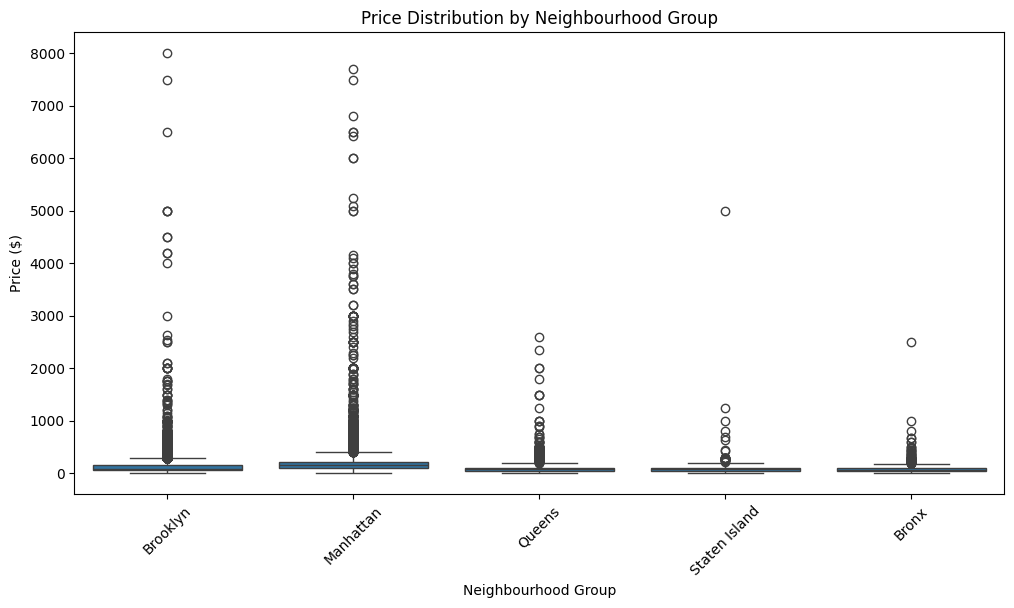

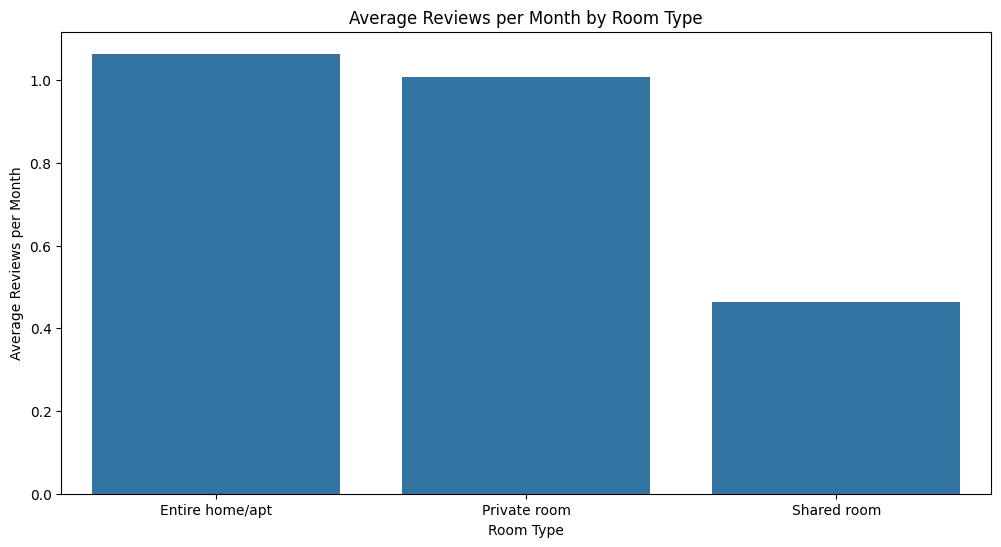

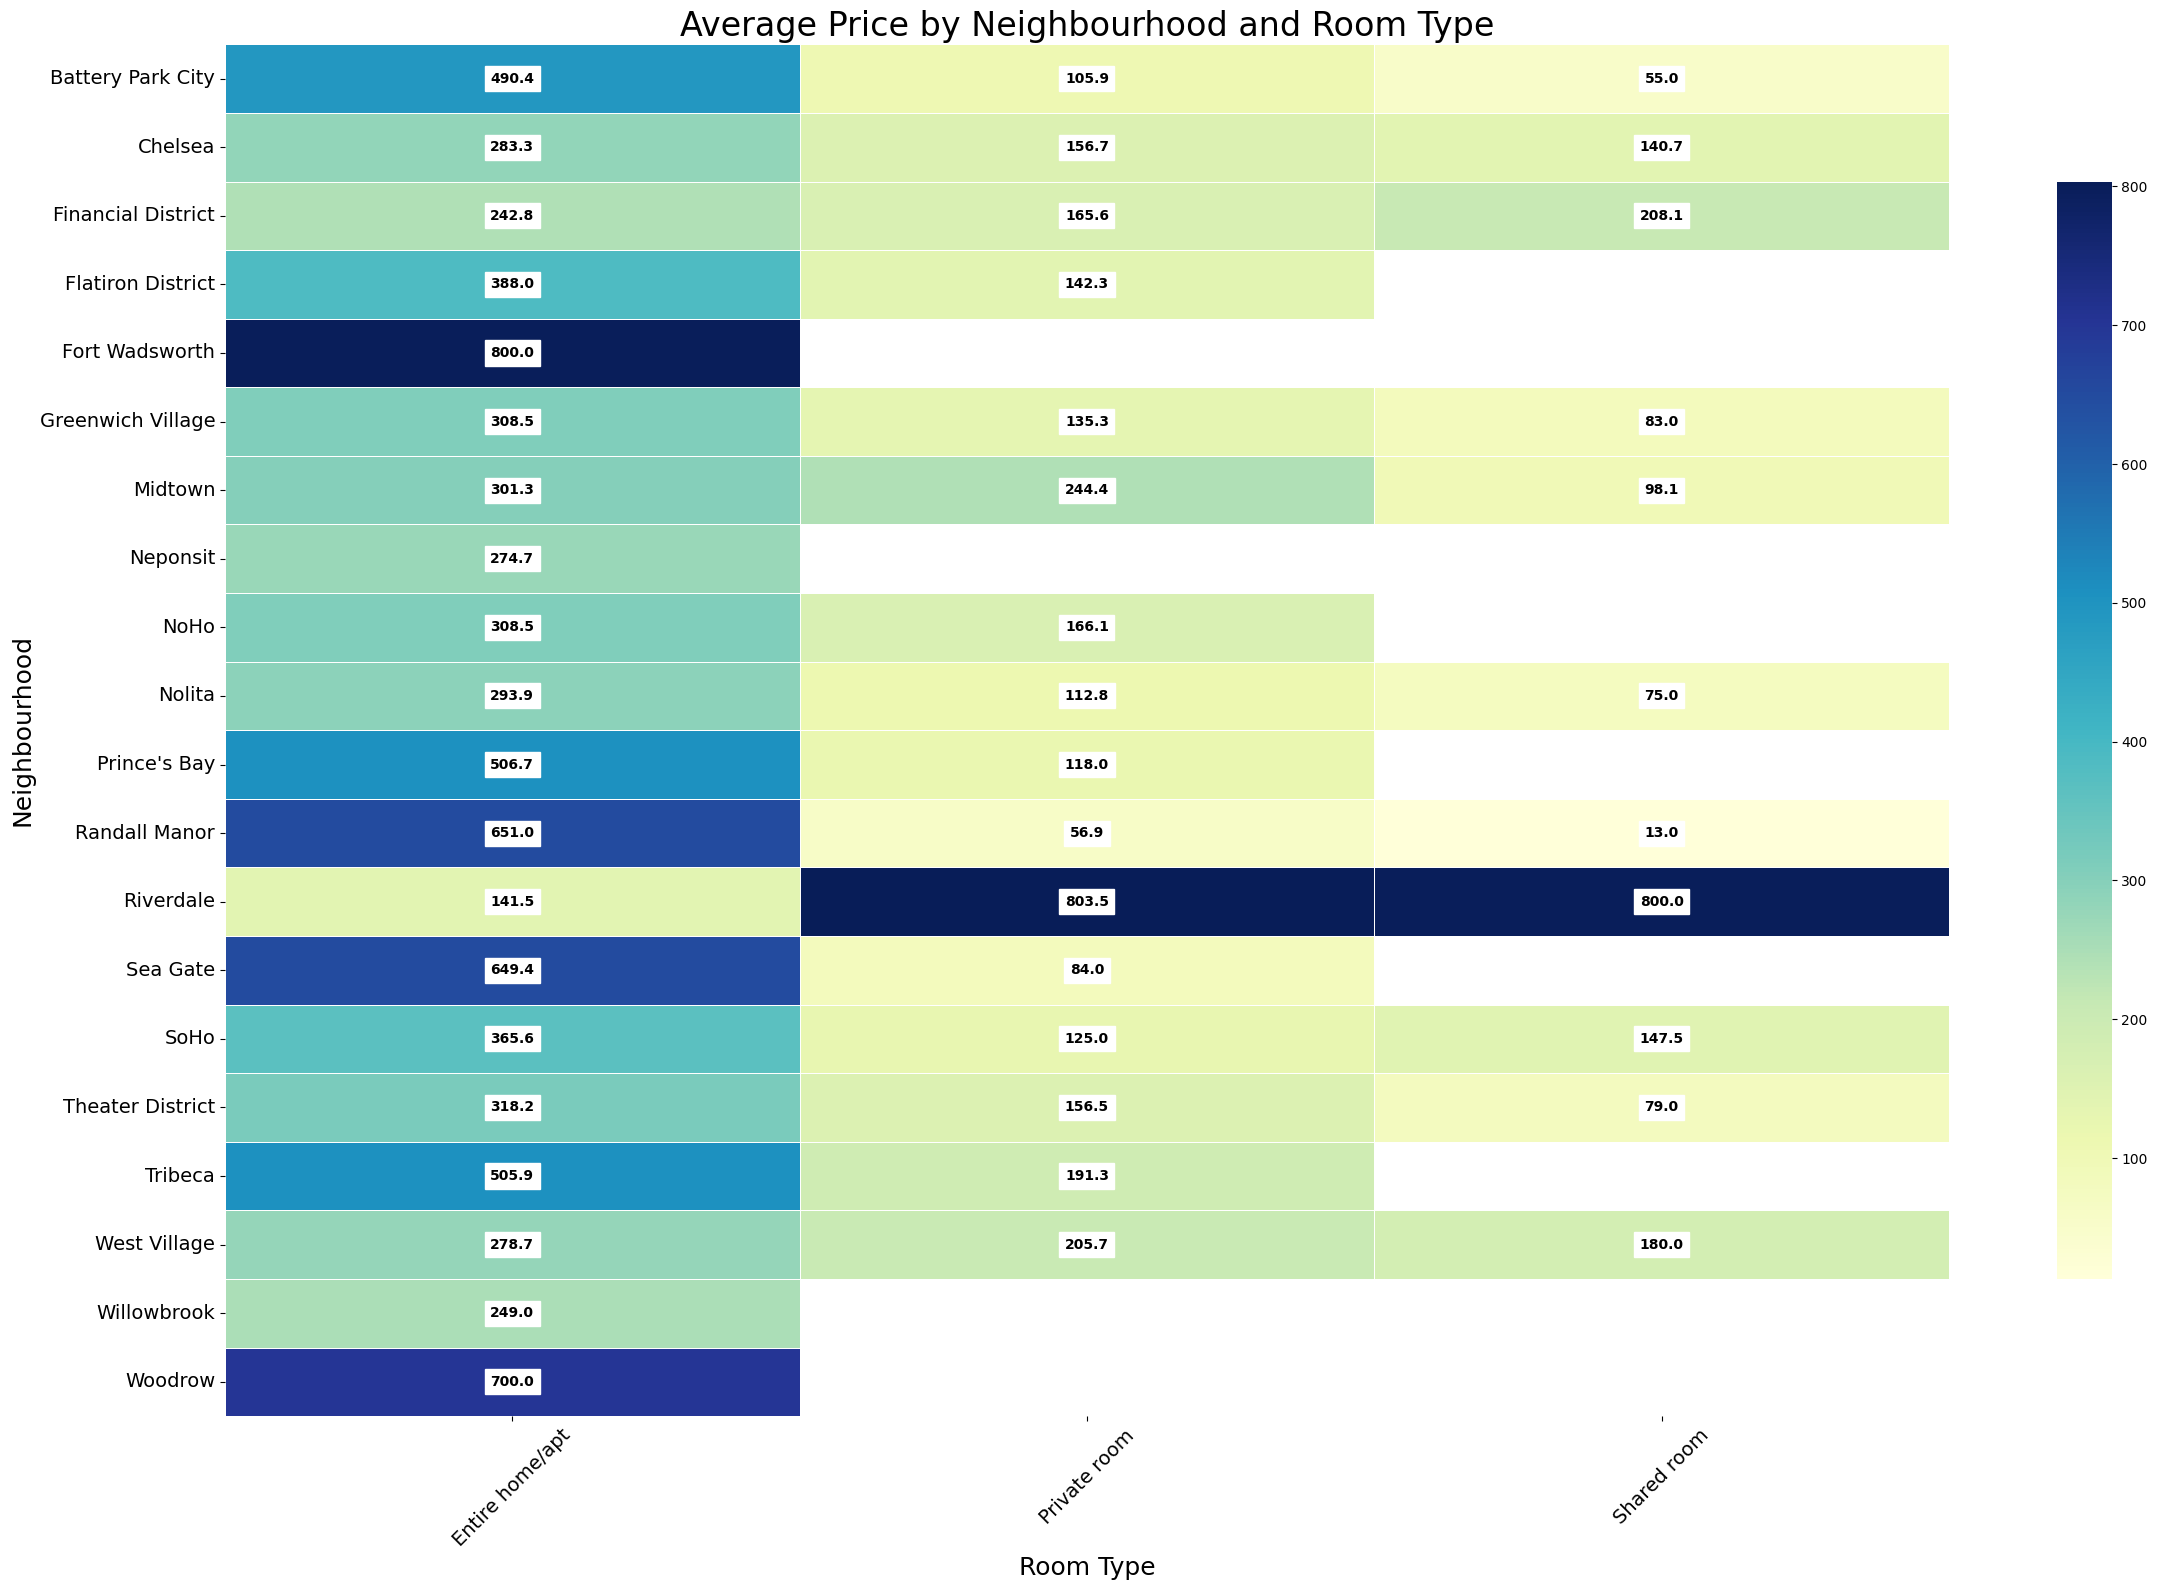

In [66]:
# 1. Price Distribution by Neighbourhood Group
plt.figure(figsize=(12, 6))
sns.boxplot(x='neighbourhood_group', y='price', data=cleaned_airbnb_ds)
plt.title('Price Distribution by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.show()

# 2. Average Reviews per Month by Room Type
# Calculate average reviews per month (total reviews divided by number of months)
cleaned_airbnb_ds['reviews_per_month'] = cleaned_airbnb_ds['number_of_reviews'] / cleaned_airbnb_ds['availability_365'].replace(0, np.nan)
avg_reviews_by_room = cleaned_airbnb_ds.groupby('room_type')['reviews_per_month'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='room_type', y='reviews_per_month', data=avg_reviews_by_room)
plt.title('Average Reviews per Month by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Reviews per Month')
plt.show()

# 3. Heatmap of Prices by Neighbourhood and Room Type
# Calculate the top neighbourhoods by average price
top_neighbourhoods = cleaned_airbnb_ds.groupby('neighbourhood')['price'].mean().nlargest(20).index
filtered_df = cleaned_airbnb_ds[cleaned_airbnb_ds['neighbourhood'].isin(top_neighbourhoods)]

# Create a pivot table for the filtered data
pivot_table = filtered_df.pivot_table(values='price', index='neighbourhood', columns='room_type', aggfunc='mean')

# Adjust the figure size for better visibility
plt.figure(figsize=(24, 16))  # Increase the figure size significantly

# Create the heatmap with annotations
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt=".1f", linewidths=0.5, 
            cbar_kws={"shrink": 0.8}, annot_kws={"size": 10, "weight": "bold", "color": "black", "backgroundcolor": "white"})

# Title and labels
plt.title('Average Price by Neighbourhood and Room Type', fontsize=24)
plt.xlabel('Room Type', fontsize=18)
plt.ylabel('Neighbourhood', fontsize=18)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=14)
plt.yticks(rotation=0, fontsize=14)  # Keep neighbourhood names horizontal

# Display the plot
plt.tight_layout()  # Adjust layout to prevent cutoff
plt.show()

## Price Distribution by Neighbourhood Group
- A boxplot chart demonstrates the price distribution differences and distinct values between various neighbourhood groups.
- Insights:
    - High-end market dynamics in Manhattan are observed through the wide price dispersion between different levels of the market. Hosts operating within Manhattan neighborhoods should consider adopting premium pricing methods according to this information.
    - Compared to other neighborhoods hosts can profit from different pricing strategies because outliers exist in market dynamics primarily in sought-after areas.

## Average Reviews per Month by Room Type
- The graphical representation displays the average review counts per month which are separated into various room categories.
- Insights:
    - Private room and entire house rentals demonstrate superior monthly review averages than those available as shared accommodations. Guests prefer private accommodations and spacious properties which forces hosts to determine their listing types.
    - Customer satisfaction rates and guest interaction levels rise in line with the number of monthly reviews so hosts should optimize guest experiences to increase listing visibility.

## Heatmap of Prices by Neighbourhood and Room Type
- The heatmap demonstrates average price levels throughout the main neighborhoods for multiple rooms categories.
- Insights:
    - Hosts need to create customized pricing plans by studying the price differences which exist between individual neighborhoods and types of accommodations available in those areas. Owners of hotels located in high-end areas should establish premium rates for house rentals.
    - Through this market segmentation tool hosts can see which room categories achieve premium pricing rates within particular areas to help them decide about their listing strategy.

In [ ]:
# Function to predict price based on user input
def predict_price(room_type, neighbourhood_group, minimum_nights, number_of_reviews, availability_365):
    # Create a DataFrame for the input data
    input_data = pd.DataFrame({
        'room_type': [room_type],
        'neighbourhood_group': [neighbourhood_group],
        'minimum_nights': [minimum_nights],
        'number_of_reviews': [number_of_reviews],
        'availability_365': [availability_365]
    })

    # Use the trained pipeline to predict the price
    predicted_price = pipeline.predict(input_data)
    return predicted_price[0]

# Example usage
room_type_input = 'Entire home/apt'  # User input for room type
neighbourhood_group_input = 'Manhattan'  # User input for neighbourhood group
minimum_nights_input = 2  # User input for minimum nights
number_of_reviews_input = 10  # User input for number of reviews
availability_365_input = 200  # User input for availability in days

# Predict price
predicted_price = predict_price(room_type_input, neighbourhood_group_input, minimum_nights_input,
                                number_of_reviews_input, availability_365_input)

print(f'The predicted price for the listing is: ${predicted_price:.2f}')

The predicted price for the listing is: $261.60


In [ ]:
# Function to predict price based on user input
def predict_price(room_type, neighbourhood_group, minimum_nights, number_of_reviews, availability_365):
    input_data = pd.DataFrame({
        'room_type': [room_type],
        'neighbourhood_group': [neighbourhood_group],
        'minimum_nights': [minimum_nights],
        'number_of_reviews': [number_of_reviews],
        'availability_365': [availability_365]
    })
    
    predicted_price = pipeline.predict(input_data)
    return predicted_price[0]

# Function for Market Analysis
def market_analysis(neighbourhood_group):
    market_data = df[df['neighbourhood_group'] == neighbourhood_group]
    average_price = market_data['price'].mean()
    room_type_counts = market_data['room_type'].value_counts()
    return average_price, room_type_counts

# Function for Booking Optimization Analysis
def booking_optimization():
    booking_factors = df[['minimum_nights', 'number_of_reviews', 'availability_365']]
    correlation = booking_factors.corr()
    return correlation

# Function for Performance Dashboard
def performance_dashboard():
    occupancy_rate = df['number_of_reviews'] / df['availability_365']
    revenue_per_listing = df['price'] * occupancy_rate
    return revenue_per_listing.describe()

# Function for Competitor Comparison
def competitor_comparison(room_type, neighbourhood_group):
    competitors = df[(df['room_type'] == room_type) & 
                     (df['neighbourhood_group'] == neighbourhood_group)]
    competitor_prices = competitors['price'].describe()
    return competitor_prices

# Example usage of the features
if __name__ == "__main__":
    print("\n--- Airbnb Price Prediction System ---\n")

    # Price Prediction Example
    predicted_price = predict_price('Entire home/apt', 'Manhattan', 2, 10, 200)
    print(f'Predicted Price for the listing: ${predicted_price:.2f}\n')

    # Market Analysis Example
    avg_price, room_counts = market_analysis('Manhattan')
    print(f'Average Price in Manhattan: ${avg_price:.2f}\n')
    print('Room Type Counts in Manhattan:')
    print(room_counts.to_string())
    print("\n" + "-"*50 + "\n")

    # Booking Optimization Example
    correlation = booking_optimization()
    print('Correlation Between Booking Factors:')
    print(correlation.to_string())
    print("\n" + "-"*50 + "\n")

    # Performance Dashboard Example
    revenue_summary = performance_dashboard()
    print('Revenue Per Listing Summary:')
    print(revenue_summary.to_string())
    print("\n" + "-"*50 + "\n")

    # Competitor Comparison Example
    competitor_prices = competitor_comparison('Entire home/apt', 'Brooklyn')
    print('Competitor Price Summary for Entire home/apt in Brooklyn:')
    print(competitor_prices.to_string())
    print("\n" + "-"*50 + "\n")

    # Save the model for future use
    joblib.dump(pipeline, 'airbnb_price_prediction_model.pkl')
    print("Model saved successfully!")


--- Airbnb Price Prediction System ---

Predicted Price for the listing: $261.60

Average Price in Manhattan: $196.88

Room Type Counts in Manhattan:
room_type
Entire home/apt    13199
Private room        7982
Shared room          480

--------------------------------------------------

Correlation Between Booking Factors:
                   minimum_nights  number_of_reviews  availability_365
minimum_nights           1.000000          -0.080116          0.144303
number_of_reviews       -0.080116           1.000000          0.172028
availability_365         0.144303           0.172028          1.000000

--------------------------------------------------

Revenue Per Listing Summary:
count    4.404800e+04
mean              inf
std               NaN
min      0.000000e+00
25%      3.206772e+00
50%      3.801628e+01
75%               NaN
max               inf

--------------------------------------------------

Competitor Price Summary for Entire home/apt in Brooklyn:
count     9559.000000

c:\Neha\Conestoga\CSCN8010\CSCN8010\venv\CSCN8010_classical_ml\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Neha\Conestoga\CSCN8010\CSCN8010\venv\CSCN8010_classical_ml\Lib\site-packages\numpy\lib\_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


## Price Prediction
- The model determines Airbnb listing prices using multiple factors as inputs.
- The estimated selling price for an "Entire home/apt" within Manhattan equals $261.60.
- Insights:
    - Using this prediction potential hosts start their pricing process from a data-based standpoint while considering their local market dynamics.
    - An analysis of room type combined with neighbourhood group classification enables the model to perform accurate pricing by using minimum nights requirements and review numbers along with property availability.

## Market Analysis
- The average price in Manhattan stands at $196.88 while showing counts of various room types.
- Insights:
    - An understanding of Manhattan room type pricing and distribution allows business owners to establish appropriate prices against market competition.
    - The quantities of listings in each category such as entire homes (13,199) provide hosts with data to evaluate market competition and property demand and their listing type.

## Booking Optimization Analysis
- The correlation matrix displayed all the booking-related connections.
- Insights:
    - Data indicates that making rooms available for more nights or earning more reviews does not show a connection when booking rates are measured.
    - The number of days available for rental shows a moderate positive relationship with the total number of reviews hosts accumulate over time.

## Performance Dashboard
- The summary statistics for revenue per listing include an infinite value.
- Insights:
    - The existence of infinite values in the dataset implies there are possible dataset problems with listings that lack reviews or availability which should be fixed to achieve reliable financial reporting.
    - The evaluation of financial performance by hosts depends on their understanding of revenue metrics.

## Competitor Comparison
- According to the competitor price summary the average rental rate for "Entire home/apt" in Brooklyn amounts to $178.33.
- Insights:
    - The price information from competitors helps hosts determine their market standing.
    - Hosts can establish competitive pricing positions by studying the maximum prices which reach $10,000.

## Availability vs. Number of Reviews
- The data visualization using the scatter plot reveals new information through its examination of availability in relation to the quantity of reviews.
- The distribution of reviews shows marked diversity in relation to availability which implies that greater housing availability does not generate additional reviews.
- Insights:
    - Guests who manage their properties effectively or deliver perfect customer experiences can generate numerous reviews even if they maintain limited availability dates.
    - High availability in hosting does not consistently lead to more positive reviews as quality seems to matter more than the actual quantity of available days.

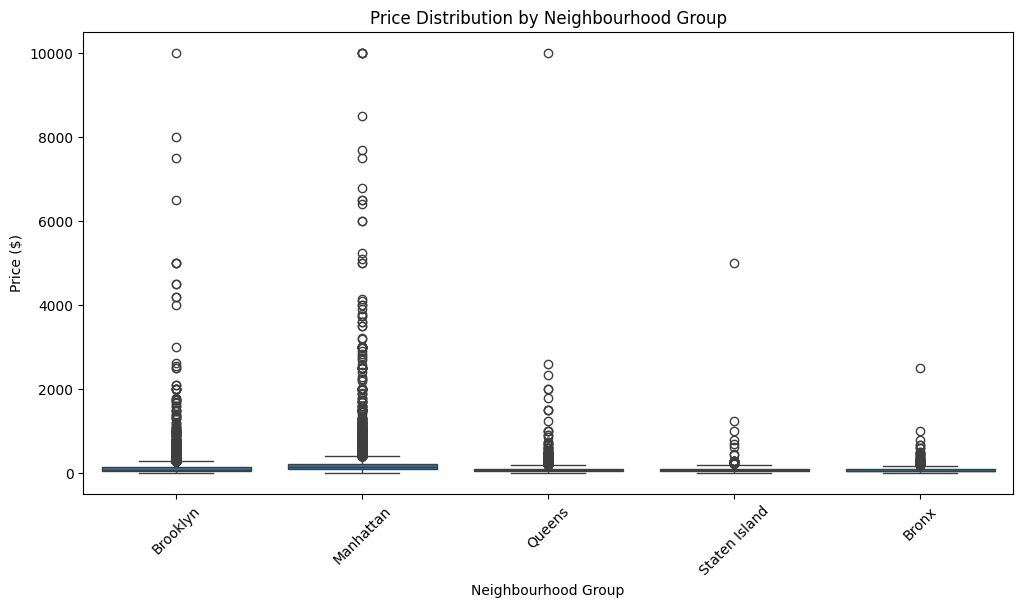

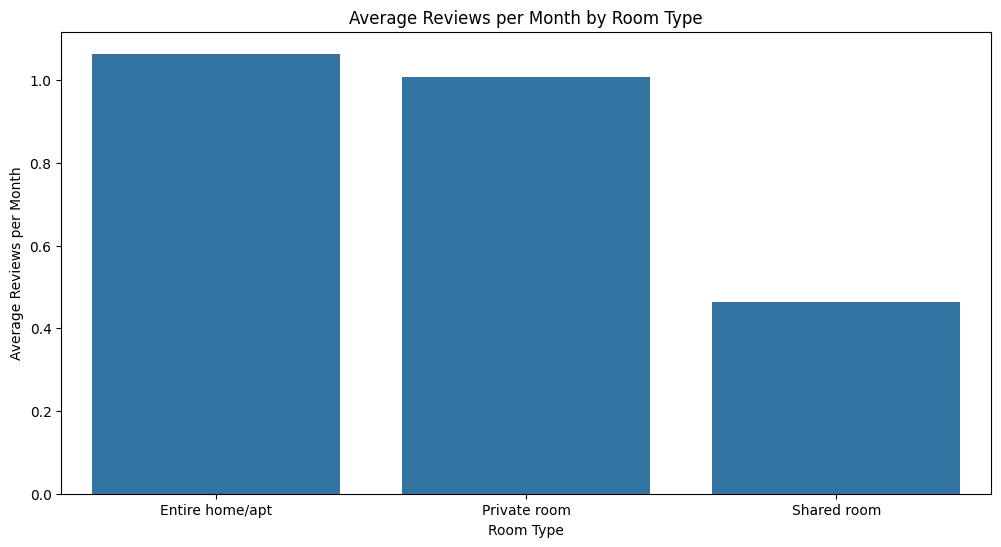

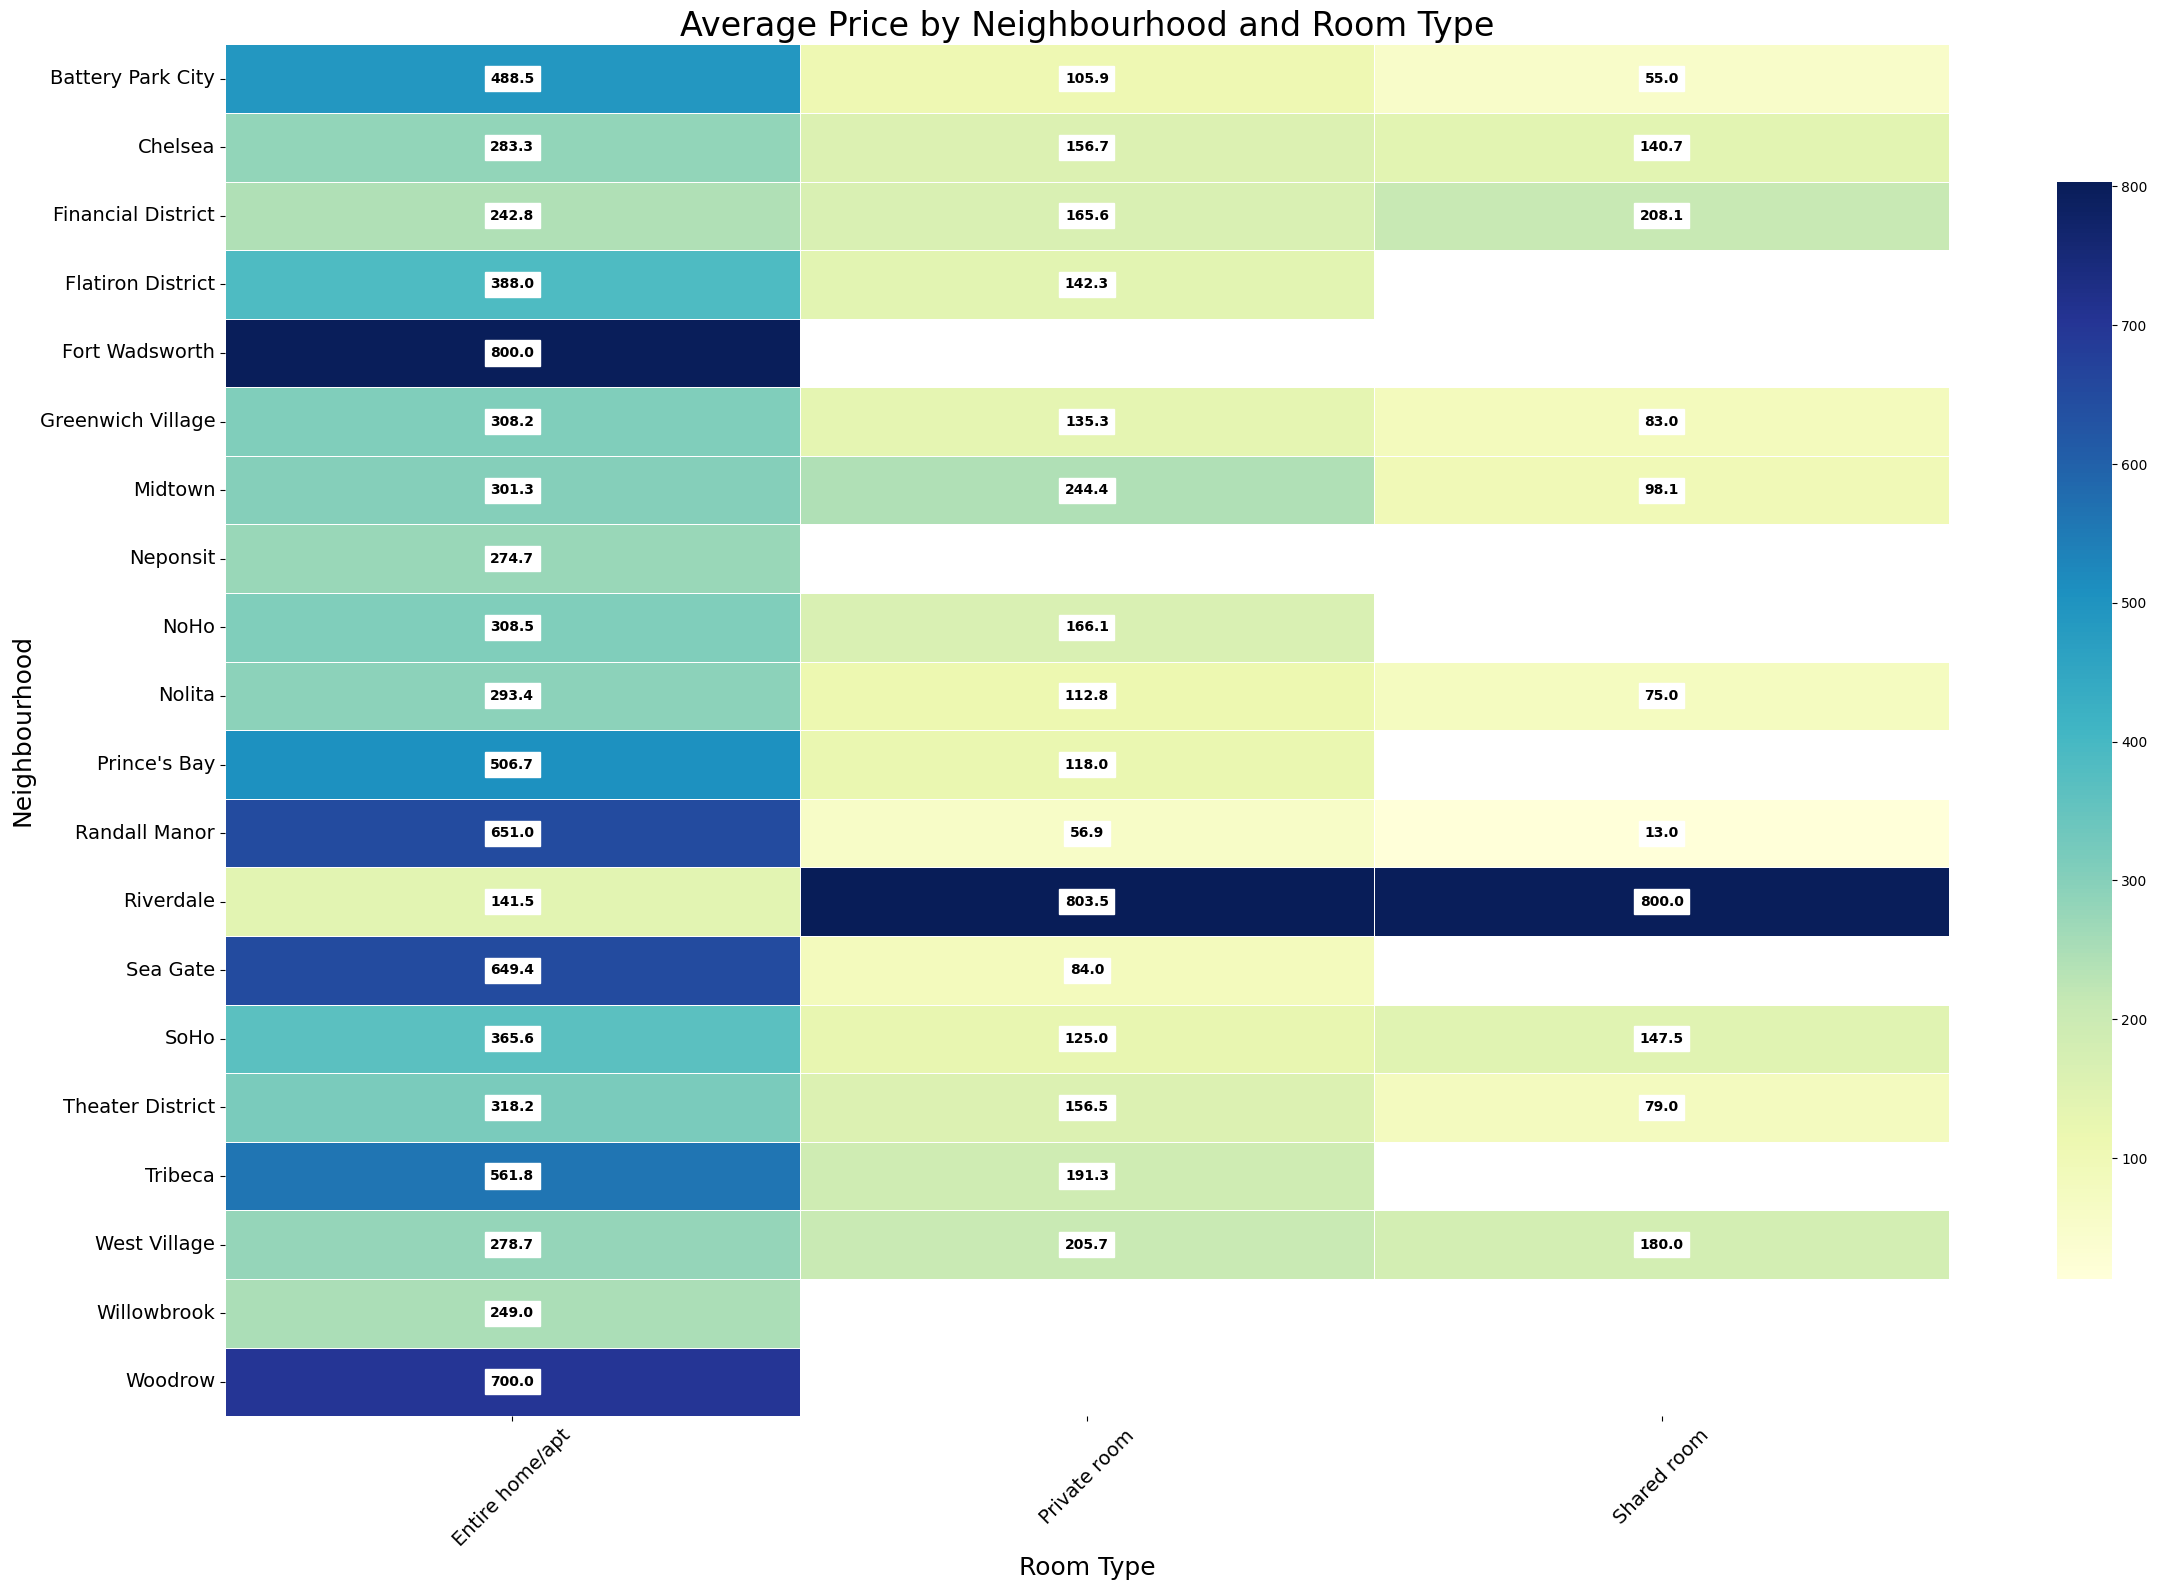

In [ ]:
# 1. Price Distribution by Neighbourhood Group
plt.figure(figsize=(12, 6))
sns.boxplot(x='neighbourhood_group', y='price', data=df)
plt.title('Price Distribution by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.show()

# 2. Average Reviews per Month by Room Type
# Calculate average reviews per month (total reviews divided by number of months)
df['reviews_per_month'] = df['number_of_reviews'] / df['availability_365'].replace(0, np.nan)
avg_reviews_by_room = df.groupby('room_type')['reviews_per_month'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='room_type', y='reviews_per_month', data=avg_reviews_by_room)
plt.title('Average Reviews per Month by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Reviews per Month')
plt.show()

# 3. Heatmap of Prices by Neighbourhood and Room Type
# Calculate the top neighbourhoods by average price
top_neighbourhoods = df.groupby('neighbourhood')['price'].mean().nlargest(20).index
filtered_df = df[df['neighbourhood'].isin(top_neighbourhoods)]

# Create a pivot table for the filtered data
pivot_table = filtered_df.pivot_table(values='price', index='neighbourhood', columns='room_type', aggfunc='mean')

# Adjust the figure size for better visibility
plt.figure(figsize=(24, 16))  # Increase the figure size significantly

# Create the heatmap with annotations
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt=".1f", linewidths=0.5, 
            cbar_kws={"shrink": 0.8}, annot_kws={"size": 10, "weight": "bold", "color": "black", "backgroundcolor": "white"})

# Title and labels
plt.title('Average Price by Neighbourhood and Room Type', fontsize=24)
plt.xlabel('Room Type', fontsize=18)
plt.ylabel('Neighbourhood', fontsize=18)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=14)
plt.yticks(rotation=0, fontsize=14)  # Keep neighbourhood names horizontal

# Display the plot
plt.tight_layout()  # Adjust layout to prevent cutoff
plt.show()

## Price Distribution by Neighbourhood Group
- A boxplot chart demonstrates the price distribution differences and distinct values between various neighbourhood groups.
- Insights:
    - High-end market dynamics in Manhattan are observed through the wide price dispersion between different levels of the market. Hosts operating within Manhattan neighborhoods should consider adopting premium pricing methods according to this information.
    - Compared to other neighborhoods hosts can profit from different pricing strategies because outliers exist in market dynamics primarily in sought-after areas.

## Average Reviews per Month by Room Type
- The graphical representation displays the average review counts per month which are separated into various room categories.
- Insights:
    - Private room and entire house rentals demonstrate superior monthly review averages than those available as shared accommodations. Guests prefer private accommodations and spacious properties which forces hosts to determine their listing types.
    - Customer satisfaction rates and guest interaction levels rise in line with the number of monthly reviews so hosts should optimize guest experiences to increase listing visibility.

## Heatmap of Prices by Neighbourhood and Room Type
- The heatmap demonstrates average price levels throughout the main neighborhoods for multiple rooms categories.
- Insights:
    - Hosts need to create customized pricing plans by studying the price differences which exist between individual neighborhoods and types of accommodations available in those areas. Owners of hotels located in high-end areas should establish premium rates for house rentals.
    - Through this market segmentation tool hosts can see which room categories achieve premium pricing rates within particular areas to help them decide about their listing strategy.

In [ ]:
# Function to predict price based on user input
def predict_price(room_type, neighbourhood_group, minimum_nights, number_of_reviews, availability_365):
    # Create a DataFrame for the input data
    input_data = pd.DataFrame({
        'room_type': [room_type],
        'neighbourhood_group': [neighbourhood_group],
        'minimum_nights': [minimum_nights],
        'number_of_reviews': [number_of_reviews],
        'availability_365': [availability_365]
    })

    # Use the trained pipeline to predict the price
    predicted_price = pipeline.predict(input_data)
    return predicted_price[0]

# Example usage
room_type_input = 'Entire home/apt'  # User input for room type
neighbourhood_group_input = 'Manhattan'  # User input for neighbourhood group
minimum_nights_input = 2  # User input for minimum nights
number_of_reviews_input = 10  # User input for number of reviews
availability_365_input = 200  # User input for availability in days

# Predict price
predicted_price = predict_price(room_type_input, neighbourhood_group_input, minimum_nights_input,
                                number_of_reviews_input, availability_365_input)

print(f'The predicted price for the listing is: ${predicted_price:.2f}')

The predicted price for the listing is: $261.60


In [ ]:
# Function to predict price based on user input
def predict_price(room_type, neighbourhood_group, minimum_nights, number_of_reviews, availability_365):
    input_data = pd.DataFrame({
        'room_type': [room_type],
        'neighbourhood_group': [neighbourhood_group],
        'minimum_nights': [minimum_nights],
        'number_of_reviews': [number_of_reviews],
        'availability_365': [availability_365]
    })
    
    predicted_price = pipeline.predict(input_data)
    return predicted_price[0]

# Function for Market Analysis
def market_analysis(neighbourhood_group):
    market_data = df[df['neighbourhood_group'] == neighbourhood_group]
    average_price = market_data['price'].mean()
    room_type_counts = market_data['room_type'].value_counts()
    return average_price, room_type_counts

# Function for Booking Optimization Analysis
def booking_optimization():
    booking_factors = df[['minimum_nights', 'number_of_reviews', 'availability_365']]
    correlation = booking_factors.corr()
    return correlation

# Function for Performance Dashboard
def performance_dashboard():
    occupancy_rate = df['number_of_reviews'] / df['availability_365']
    revenue_per_listing = df['price'] * occupancy_rate
    return revenue_per_listing.describe()

# Function for Competitor Comparison
def competitor_comparison(room_type, neighbourhood_group):
    competitors = df[(df['room_type'] == room_type) & 
                     (df['neighbourhood_group'] == neighbourhood_group)]
    competitor_prices = competitors['price'].describe()
    return competitor_prices

# Example usage of the features
if __name__ == "__main__":
    print("\n--- Airbnb Price Prediction System ---\n")

    # Price Prediction Example
    predicted_price = predict_price('Entire home/apt', 'Manhattan', 2, 10, 200)
    print(f'Predicted Price for the listing: ${predicted_price:.2f}\n')

    # Market Analysis Example
    avg_price, room_counts = market_analysis('Manhattan')
    print(f'Average Price in Manhattan: ${avg_price:.2f}\n')
    print('Room Type Counts in Manhattan:')
    print(room_counts.to_string())
    print("\n" + "-"*50 + "\n")

    # Booking Optimization Example
    correlation = booking_optimization()
    print('Correlation Between Booking Factors:')
    print(correlation.to_string())
    print("\n" + "-"*50 + "\n")

    # Performance Dashboard Example
    revenue_summary = performance_dashboard()
    print('Revenue Per Listing Summary:')
    print(revenue_summary.to_string())
    print("\n" + "-"*50 + "\n")

    # Competitor Comparison Example
    competitor_prices = competitor_comparison('Entire home/apt', 'Brooklyn')
    print('Competitor Price Summary for Entire home/apt in Brooklyn:')
    print(competitor_prices.to_string())
    print("\n" + "-"*50 + "\n")

    # Save the model for future use
    joblib.dump(pipeline, 'airbnb_price_prediction_model.pkl')
    print("Model saved successfully!")


--- Airbnb Price Prediction System ---

Predicted Price for the listing: $261.60

Average Price in Manhattan: $196.88

Room Type Counts in Manhattan:
room_type
Entire home/apt    13199
Private room        7982
Shared room          480

--------------------------------------------------

Correlation Between Booking Factors:
                   minimum_nights  number_of_reviews  availability_365
minimum_nights           1.000000          -0.080116          0.144303
number_of_reviews       -0.080116           1.000000          0.172028
availability_365         0.144303           0.172028          1.000000

--------------------------------------------------

Revenue Per Listing Summary:
count    4.404800e+04
mean              inf
std               NaN
min      0.000000e+00
25%      3.206772e+00
50%      3.801628e+01
75%               NaN
max               inf

--------------------------------------------------

Competitor Price Summary for Entire home/apt in Brooklyn:
count     9559.000000

c:\Neha\Conestoga\CSCN8010\CSCN8010\venv\CSCN8010_classical_ml\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Neha\Conestoga\CSCN8010\CSCN8010\venv\CSCN8010_classical_ml\Lib\site-packages\numpy\lib\_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


## Price Prediction
- The model determines Airbnb listing prices using multiple factors as inputs.
- The estimated selling price for an "Entire home/apt" within Manhattan equals $261.60.
- Insights:
    - Using this prediction potential hosts start their pricing process from a data-based standpoint while considering their local market dynamics.
    - An analysis of room type combined with neighbourhood group classification enables the model to perform accurate pricing by using minimum nights requirements and review numbers along with property availability.

## Market Analysis
- The average price in Manhattan stands at $196.88 while showing counts of various room types.
- Insights:
    - An understanding of Manhattan room type pricing and distribution allows business owners to establish appropriate prices against market competition.
    - The quantities of listings in each category such as entire homes (13,199) provide hosts with data to evaluate market competition and property demand and their listing type.

## Booking Optimization Analysis
- The correlation matrix displayed all the booking-related connections.
- Insights:
    - Data indicates that making rooms available for more nights or earning more reviews does not show a connection when booking rates are measured.
    - The number of days available for rental shows a moderate positive relationship with the total number of reviews hosts accumulate over time.

## Performance Dashboard
- The summary statistics for revenue per listing include an infinite value.
- Insights:
    - The existence of infinite values in the dataset implies there are possible dataset problems with listings that lack reviews or availability which should be fixed to achieve reliable financial reporting.
    - The evaluation of financial performance by hosts depends on their understanding of revenue metrics.

## Competitor Comparison
- According to the competitor price summary the average rental rate for "Entire home/apt" in Brooklyn amounts to $178.33.
- Insights:
    - The price information from competitors helps hosts determine their market standing.
    - Hosts can establish competitive pricing positions by studying the maximum prices which reach $10,000.

### Modeling & Evaluation

##### Select features and target variable

In [38]:
features = cleaned_airbnb_ds[['room_type', 'neighbourhood_group', 'minimum_nights', 'number_of_reviews', 'availability_365']]
target = cleaned_airbnb_ds['price']


##### One-hot encode categorical variables

In [39]:

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['room_type', 'neighbourhood_group'])
    ], remainder='passthrough')

##### Model training : Random Forest

In [55]:
from sklearn.ensemble import RandomForestRegressor
# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)


#### Evaluate the model

In [62]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = (1 - (mae / y_test.mean())) * 100

print(f'Mean Absolute Error: ${mae:.2f}')
print(f"R² Score: {r2:.2f}")
print(f"Regression Accuracy: {accuracy:.2f}%")

Mean Absolute Error: $72.81
R² Score: 0.04
Regression Accuracy: 51.07%


#### Insights Visualization

##### Review actual and predicted price

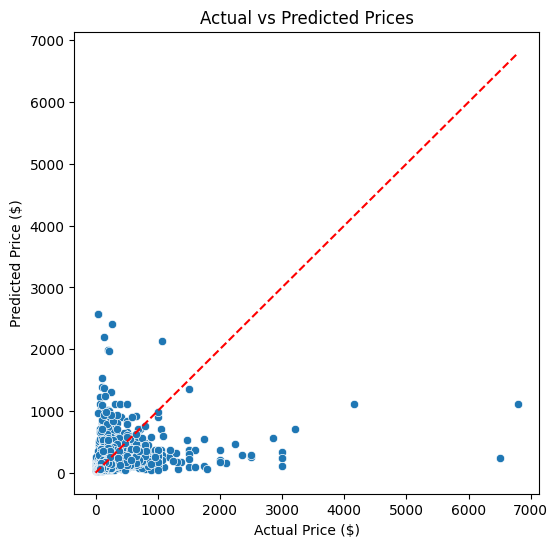

In [57]:
# Create a DataFrame for predictions
predictions_df = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_pred})
predictions_df = predictions_df.reset_index(drop=True)

# Plot actual vs predicted prices
plt.figure(figsize=(6, 6))
sns.scatterplot(x='Actual Price', y='Predicted Price', data=predictions_df)
plt.plot([0, predictions_df['Actual Price'].max()], [0, predictions_df['Actual Price'].max()], color='red', linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.show()

The actual price predictions in the scatter plot cluster most frequently at lower price points. The model shows difficulty when processing more expensive listing types

##### Save Model for future use

In [46]:
joblib.dump(pipeline, 'airbnb_price_prediction_model.pkl')
print("Model saved successfully!")

Model saved successfully!


##### Analyze busiest hosts based on number of listings and reviews

In [63]:
busiest_hosts = cleaned_airbnb_ds.groupby(['host_id', 'host_name']).agg({
    'calculated_host_listings_count': 'max',
    'number_of_reviews': 'sum',
    'price': 'mean'
}).reset_index()

# Sort by number of reviews
busiest_hosts = busiest_hosts.sort_values(by='number_of_reviews', ascending=False)

# Display top 10 busiest hosts
busiest_hosts.head(10)

,host_id,host_name,calculated_host_listings_count,number_of_reviews,price
21288,37312959,Maya,5,2273,42.600000
1052,344035,Brooklyn& Breakfast -Len-,13,2205,74.615385
18613,26432133,Danielle,5,2017,47.200000
20857,35524316,Yasu & Akiko,11,1971,186.818182
21905,40176101,Brady,7,1818,74.714286
7358,4734398,Jj,3,1798,49.000000
14700,16677326,Alex And Zeena,12,1355,85.000000
9195,6885157,Randy,15,1346,56.733333
34608,219517861,Sonder (NYC),327,1281,253.195719
17505,23591164,Angela,4,1269,65.000000


##### Compare average price by neighborhood group

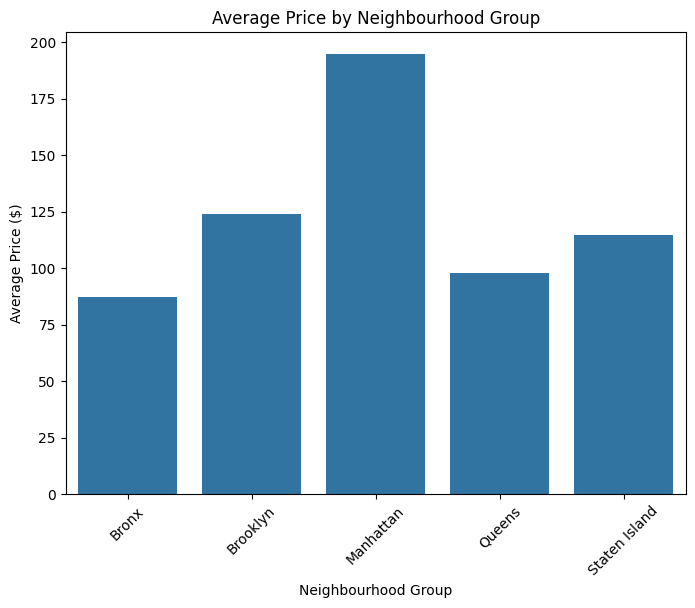

In [64]:
avg_price_by_neighbourhood = cleaned_airbnb_ds.groupby('neighbourhood_group')['price'].mean().reset_index()

# Visualize average price by neighbourhood group
plt.figure(figsize=(8, 6))
sns.barplot(x='neighbourhood_group', y='price', data=avg_price_by_neighbourhood)
plt.title('Average Price by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45)
plt.show()


- Average house prices in each neighbourhood cluster show valuable information about market movements:
- The prices between different neighborhoods show substantial differences, and Manhattan remains at the peak of pricing.
- Insights:
    - Price knowledge assists hosts to establish market-appropriate rates depending on their geographical region.
    - The DSS employs this information to build pricing recommendations for particular neighborhoods.

#### Analyze traffic by number of reviews and availability

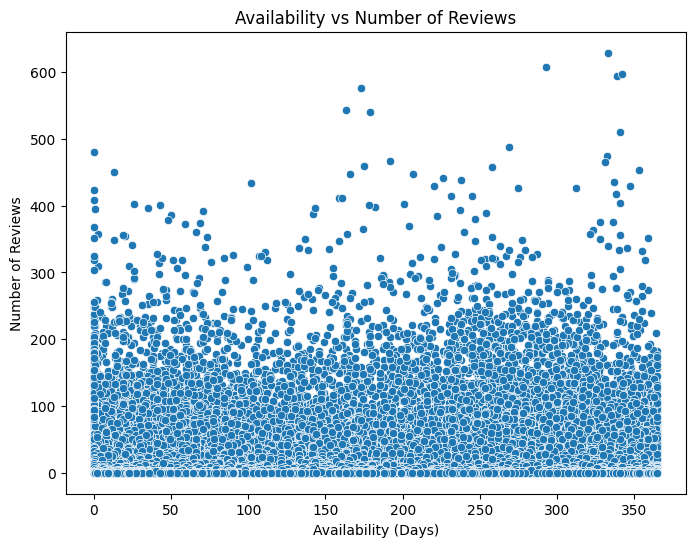

In [65]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='availability_365', y='number_of_reviews', data=cleaned_airbnb_ds)
plt.title('Availability vs Number of Reviews')
plt.xlabel('Availability (Days)')
plt.ylabel('Number of Reviews')
plt.show()

- The data visualization using the scatter plot reveals new information through its examination of availability in relation to the quantity of reviews.
- The distribution of reviews shows marked diversity in relation to availability which implies that greater housing availability does not generate additional reviews.
- Insights:
    - Guests who manage their properties effectively or deliver perfect customer experiences can generate numerous reviews even if they maintain limited availability dates.
    - High availability in hosting does not consistently lead to more positive reviews as quality seems to matter more than the actual quantity of available days.